 - configura a seed das funções randomicas, para reproducibilidade;
 - desativa a GPU;

In [1]:
import numpy as np
import tensorflow as tf
import os
np.random.seed(1337)  # for reproducibility
tf.random.set_seed(1337)
os.environ['TF_DETERMINISTIC_OPS'] = str(1)


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Carregando dados e features.

A função load_data precura pelo arquivo `.csv`, caso não o encontre, irá baixar/construir os dados e montar este arquivo csv

In [2]:
from data.utils import load_data
from data.scaling import normalize
coin = 'ADA'
df = load_data(coin, 'cardano', event_days_left_lookback=5).iloc[:, :]
df.head()

,tweet_volume,trend,price,price (%),days_to_event_happen,event_title,event_votes,event_confidence,event_in_1_days_votes,event_in_1_days_confidence,event_in_2_days_votes,event_in_2_days_confidence,event_in_3_days_votes,event_in_3_days_confidence,event_in_4_days_votes,event_in_4_days_confidence,event_in_5_days_votes,event_in_5_days_confidence
date,,,,,,,,,,,,,,,,,,
2014-04-09,502.0,0.598,11.268,0.000000,<NA>,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-04-10,961.0,0.643,10.015,-0.111200,<NA>,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-04-11,954.0,0.601,10.136,0.012082,<NA>,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-04-12,454.0,0.405,10.964,0.081689,<NA>,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-04-13,815.0,0.441,10.388,-0.052536,<NA>,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


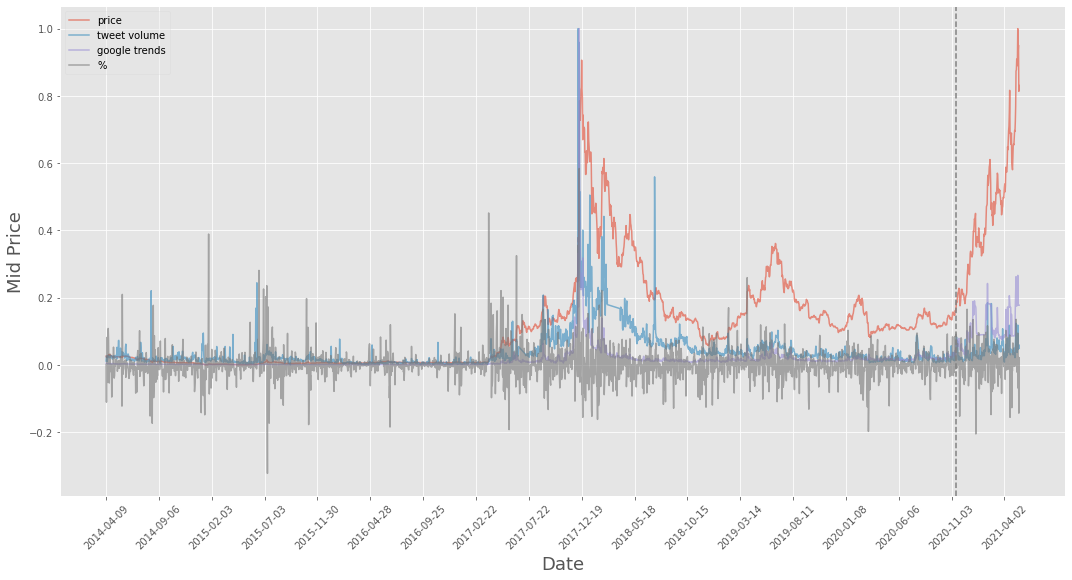

<module 'matplotlib.pyplot' from 'C:\\Users\\jgmu6\\AppData\\Local\\Programs\\Python\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [3]:
from data.visualization import plot_data
prices, _ = normalize(df.loc[:, 'price'].to_numpy(), range=(0,1))
variation = df.loc[:, 'price'].pct_change().fillna(0).to_numpy()
tweet, _ = normalize(df.loc[:, 'tweet_volume'].to_numpy(), range=(0,1))
google_trends, _ = normalize(df.loc[:, 'trend'].to_numpy(), range=(0,1))
plot_data([prices, tweet, google_trends, variation], 
          legends=['price', 'tweet volume', 'google trends', '%'], tick=150,
          verticalLineAt=len(prices)*0.93, labels=df.index.date[::150], blocking=False)

Carrega e normaliza (entre -1 e 1) as **features de preço**, **variação de preço**, **volume de tweets** e **google trends**.<br/>
variação de preço, volume de tweets e google trends são expressos em porcentagem/variação.

In [4]:
prices, _ = normalize(df.loc[:, 'price'].to_numpy())
# variation = df.loc[:, 'price (%)'].to_numpy()
variation = df.loc[:, 'price'].pct_change().fillna(0).to_numpy()
tweet, _ = normalize(df.loc[:, 'tweet_volume'].pct_change().fillna(0).to_numpy())
google_trends, _ = normalize(df.loc[:, 'trend'].pct_change().fillna(0).to_numpy())

prices[:3], variation[:3], google_trends[:3]

(array([-0.94864721, -0.95510821, -0.95448428]),
 array([ 0.        , -0.11119986,  0.01208188]),
 array([-0.5917465 , -0.55042753, -0.62761196]))

carrega as **features de eventos**.

Seja _**N**_ a quantidade de passos (dias) que a chegada de um evento deve ser informada com antecedência,<br/>
2(_**N**_ + 1) séries temporais de eventos são carregadas, onde:
 - para a quantidade de votos de um evento, 1 indicará o anúncio de um evento + _**N**_ indicarão quantos dias faltam.
 - para a confiabilidade de um evento, 1 indicará o anúncio de um evento + _**N**_ indicação quantos dias faltam.

Cada série temporal representa quantos dias faltam para um evento chegar. Por exemplo:<br/>
para<br/> 
 - `N=3`
 - `Evento A - anunciado dia 0 - acontece dia 6 - pontuação 2 - confiabilidade 0.9`
 - `Evento B - anunciado dia 5 - acontece dia 8 - pontuação 3 - confiabilidade 0.7`

        as seguintes series temporais serão criadas:

>>
`anuncio_de_evento_votes = [2,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0]`<br/>
`evento_falta_3_dia_votes= [0,  0,  0,  2,  0,  3,  0,  0,  0,  0,  0]`<br/>
`evento_falta_2_dia_votes= [0,  0,  0,  0,  2,  0,  3,  0,  0,  0,  0]`<br/>
`evento_falta_1_dia_votes= [0,  0,  0,  0,  0,  2,  0,  3,  0,  0,  0]`<br/>

>>
`anuncio_de_evento_confi = [.9,0,  0,  0,  0,.7,  0,  0,  0,  0,  0]`<br/>
`evento_falta_3_dia_confi= [0,  0,  0,.9,  0,.7,  0,  0,  0,  0,  0]`<br/>
`evento_falta_2_dia_confi= [0,  0,  0,  0,.9,  0,.7,  0,  0,  0,  0]`<br/>
`evento_falta_1_dia_confi= [0,  0,  0,  0,  0,.9,  0,.7,  0,  0,  0]`<br/>

para mais detalhes veja a função `eventTimeSeries_to_many()` em [data/utils.py](./data/utils.py)


Aqui o scaler (objeto que normaliza os dados) da série temporal `votos de anúncio de evento` e `confiabilidade de anúncio de evento` são aplicados também 

In [5]:
# event_day_count, _ = normalize(df.loc[:, 'days_to_event_happen'].fillna(0).to_numpy())
event_votes, votes_scaler = normalize(df.loc[:, 'event_votes'].fillna(0).to_numpy())
event_confidence, conf_scaler = normalize(df.loc[:, 'event_confidence'].fillna(0).to_numpy())
event_features = []
for i in range(5):
    votes, confidence = df[f'event_in_{i+1}_days_votes'].to_numpy(), df[f'event_in_{i+1}_days_confidence'].to_numpy()
    votes =  votes_scaler.transform(votes.reshape(-1,1)).reshape(-1)
    confidence =  conf_scaler.transform(confidence.reshape(-1,1)).reshape(-1)

    event_features.append(votes)
    event_features.append(confidence)

 
# se mostraram meio inuteis, optei por não inclui-los nas features
# df = add_indicadores_tecnicos(df)
# MACD_50_200_21, _ = normalize(df.loc[:, 'MACD_50_200_21'].to_numpy())
# MACDh_50_200_21, _ = normalize(df.loc[:, 'MACDh_50_200_21'].to_numpy())
# MACDs_50_200_21, _ = normalize(df.loc[:, 'MACDs_50_200_21'].to_numpy())
# BB_Middle_Band, _ = normalize(df.loc[:, 'BB_Middle_Band'].to_numpy())
# BB_Upper_Band, _ = normalize(df.loc[:, 'BB_Upper_Band'].to_numpy())
# BB_Lower_Band, _ = normalize(df.loc[:, 'BB_Lower_Band'].to_numpy())

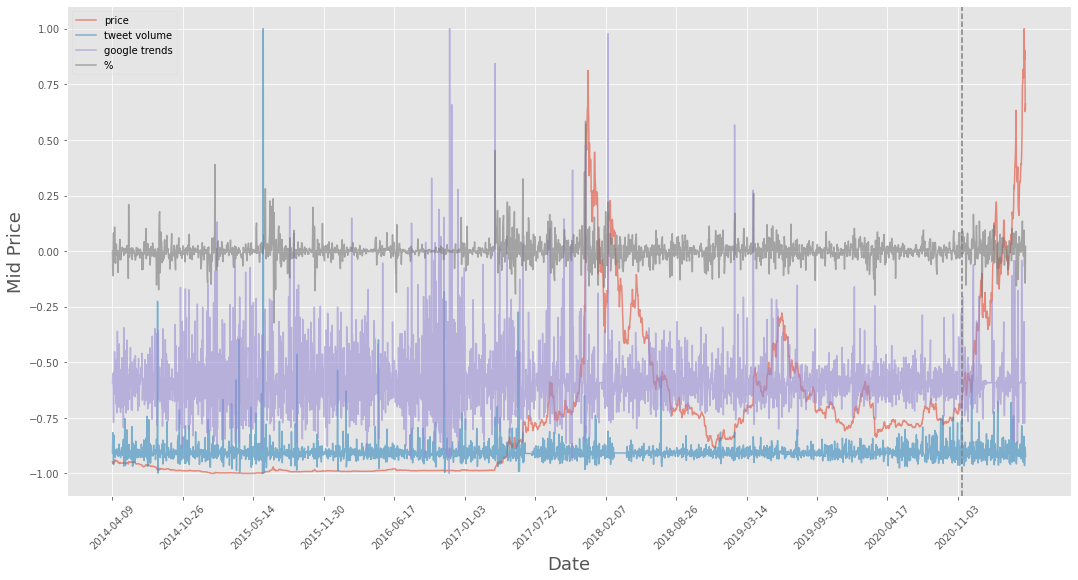

<module 'matplotlib.pyplot' from 'C:\\Users\\jgmu6\\AppData\\Local\\Programs\\Python\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [6]:
from data.visualization import plot_data
plot_data([prices, tweet, google_trends, variation], 
          legends=['price', 'tweet volume', 'google trends', '%'], tick=200,
          verticalLineAt=len(prices)*0.93, labels=df.index.date[::200], blocking=False)

## Preparando os dados

transformando os dados para o formato de entrada do modelo

A entrada tem o formato (_n_samples_, _n_lookback, _n_features_), enquanto a saída tem o formato (_n_samples_, 2).

A saída tem 2 valores para cada amosta pelo seguinte motivo: uma função loss personalizada é usada, e tal função precisa do valor da saída do passo/timestep anterior, como uma "label auxiliar" <br/>
Então cada label de amostra, de formato (1, 2), tem no **primeiro valor** o resultado verdadeiro do **passo anterior**, e no **segundo valor** o resultado esperado do **atual passo**, isto é, da amostra a qual era corresponde.


In [7]:
from typing import Tuple
# look_behind: passos (dias) anteriores usados para prever o proximo.
N = 5
foward_days = 1  # quantos dias prever
used_features_names = ['tweet', 'variation', 'trends']
features = [prices, variation, google_trends] + event_features
target = prices

def to_keras_format(features: list, target) -> Tuple[np.array, np.array]:
    n_samples = len(target) - N - (foward_days-1)
    # matriz de dimensao: [n_samples, N, n_features];
    features_set = np.empty((n_samples, N, len(features)))  # type: np.ndarray
    labels = [None]*n_samples
    for i in range(n_samples):
        for j in range(N):
            for ft_idx in range(len(features)):
                feature = features[ft_idx]
                features_set[i, j, ft_idx] = feature[i+j]

        labels[i] = target[N+i-1: N+i+foward_days]
    labels = np.array(labels)

    return features_set, labels

features_set, labels = to_keras_format(features, target)
print(features_set.shape, labels.shape)
print(f'ultimo valor em cada amostra:\n{features_set[:3, -1, 0:1]}\n...')
print(f'label auxiliar, label verdadeira:\n{labels[:3]}\n...')

(2588, 5, 13) (2588, 2)
ultimo valor em cada amostra:
[[-0.95318486]
 [-0.94962693]
 [-0.9434547 ]]
...
label auxiliar, label verdadeira:
[[-0.95318486 -0.94962693]
 [-0.94962693 -0.9434547 ]
 [-0.9434547  -0.93888611]]
...


In [8]:
from data.utils import split_data
print('dividindo os dados em treino e teste')
# shuffle_mask = np.arange(len(features_set))
# np.random.shuffle(shuffle_mask)
# features_set_shuffled, labels_shuffled = features_set[shuffle_mask], labels[shuffle_mask]

train_X, test_X = split_data(features_set, ratio=0.85)
train_y, test_y = split_data(labels, ratio=0.85)

print(f'train_X and test_X shape = {train_X.shape} {test_X.shape}')
print(f'train_y and test_y shape = {train_y.shape} {test_y.shape}')

dividindo os dados em treino e teste
train_X and test_X shape = (2199, 5, 13) (389, 5, 13)
train_y and test_y shape = (2199, 2) (389, 2)


# Construindo o modelo

In [9]:
from keras.models import Model
from keras.layers import Input, LSTM, Dropout, Dense

def build_model(train_X, train_y) -> Model:
    inputs = Input(shape=train_X.shape[1:])
    # lstm = LSTM(units=250, return_sequences=True, input_shape=train_X.shape[1:])(inputs)
    # lstm = Dropout(0.15)(lstm)

    lstm = LSTM(units=750, return_sequences=False, input_shape=train_X.shape[1:])(inputs)
    lstm = Dropout(0.15)(lstm)
    x = lstm
    # time_embedding = TimeDistributed(Time2Vec(kernel_size=1))(lstm)
    # x = concatenate([lstm, time_embedding], -1)

    # x = tf_MultiHeadAttention(num_heads=4, head_size=96,output_size=250,  dropout=0.15)((x,x))
    # x = LayerNormalization(epsilon=1e-6)(Add()([lstm,x]))
    # x = Conv1D(filters=128, kernel_size=1, activation='relu')(x)
    # x = LayerNormalization(epsilon=1e-6)(Add()([lstm,x]))

    # avg_pool = GlobalAveragePooling1D()(x)
    # x = GlobalMaxPooling1D()(lstm)
    # x = concatenate([avg_pool, max_pool])

    x = Dense(units=175, activation='linear')(x)
    x = Dropout(0.15)(x)
    x = Dense(units=75, activation='linear')(x)
    x = Dropout(0.15)(x)
    x = Dense(units=foward_days)(x)
    return Model(inputs=inputs, outputs=x)
    

modelo = build_model(train_X, train_y)

from keras.losses import mean_squared_error as keras_mean_squared_error, cosine_similarity as keras_cosine_similarity
from metrics.custom import custom_loss2, custom_loss, above_or_below_zero_accuracy, movement_accuracy
from metrics.custom import mean_squared_error, cosine_similarity as custom_cosine_similarity


opt = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
modelo.compile(optimizer=opt, loss=custom_loss2, metrics=[mean_squared_error, movement_accuracy, above_or_below_zero_accuracy])# 'cosine_similarity', 'mean_squared_error'

modelo.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 13)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 750)               2292000   
_________________________________________________________________
dropout (Dropout)            (None, 750)               0         
_________________________________________________________________
dense (Dense)                (None, 175)               131425    
_________________________________________________________________
dropout_1 (Dropout)          (None, 175)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 75)                13200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 75)                0     

## treinando o modelo

In [10]:
modelo.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=40, batch_size=64)  # validation_data=(test_X, test_y)
epochs = len(modelo.history.epoch)
print('Modelo treinado')

Epoch 1/40
35/35 [==============================] - 6s 110ms/step - loss: 12.8176 - mean_squared_error: 0.3884 - movement_accuracy: 0.4949 - above_or_below_zero_accuracy: 0.9660 - val_loss: 3.3133 - val_mean_squared_error: 0.1773 - val_movement_accuracy: 0.4545 - val_above_or_below_zero_accuracy: 0.7188
Epoch 2/40
35/35 [==============================] - 2s 62ms/step - loss: 0.4977 - mean_squared_error: 0.0280 - movement_accuracy: 0.4882 - above_or_below_zero_accuracy: 0.9787 - val_loss: 0.0762 - val_mean_squared_error: 0.0078 - val_movement_accuracy: 0.5402 - val_above_or_below_zero_accuracy: 0.9688
Epoch 3/40
35/35 [==============================] - 2s 62ms/step - loss: 0.0942 - mean_squared_error: 0.0080 - movement_accuracy: 0.5340 - above_or_below_zero_accuracy: 0.9925 - val_loss: 0.1443 - val_mean_squared_error: 0.0094 - val_movement_accuracy: 0.4607 - val_above_or_below_zero_accuracy: 0.9509
Epoch 4/40
35/35 [==============================] - 2s 60ms/step - loss: 0.0896 - mean_sq

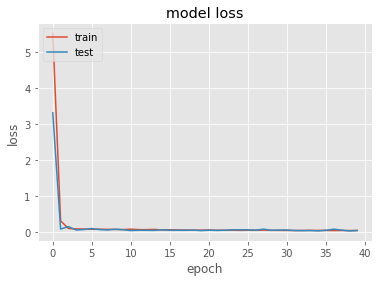

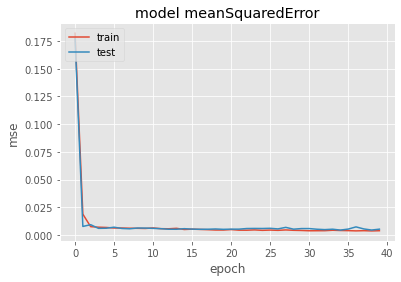

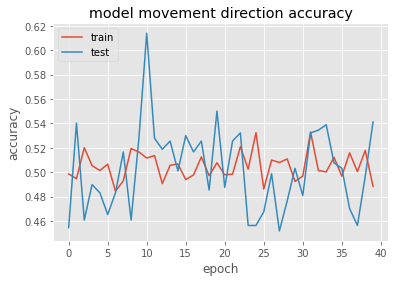

In [11]:
from matplotlib import pyplot as plt
# vizualizando estatisticas do modelo em si e seu treino
def plot_train_history(modelo: Model, plot_above_or_below_zero_accuracy: bool):
    plt.plot(modelo.history.history['loss'])
    plt.plot(modelo.history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show(block=True)

    plt.plot(modelo.history.history['mean_squared_error'])
    plt.plot(modelo.history.history['val_mean_squared_error'])
    plt.title('model meanSquaredError')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show(block=True)

    plt.plot(modelo.history.history['movement_accuracy'])
    plt.plot(modelo.history.history['val_movement_accuracy'])
    plt.title('model movement direction accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show(block=True)

    # plote esse apenas se seu dado target for de variação (não faz sentido para dado bruto)
    if plot_above_or_below_zero_accuracy:
        plt.plot(modelo.history.history['above_or_below_zero_accuracy'])
        plt.plot(modelo.history.history['val_above_or_below_zero_accuracy'])
        plt.title('price up or down accuracy *')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show(block=True)

plot_train_history(modelo, plot_above_or_below_zero_accuracy=False)

## resultados

In [12]:
# PREVISAAAAOOO
from keras.losses import mean_squared_error as keras_mean_squared_error, cosine_similarity as keras_cosine_similarity

train_score = modelo.evaluate(x=train_X, y=train_y, batch_size=16)
test_score = modelo.evaluate(x=test_X, y=test_y, batch_size=16)
print('Train Score:', train_score)
print('Test Score:', test_score)
#predictions = scaler.inverse_transform(predictions)

#timestep_size = 1./len(features_set)
testPredict = modelo.predict(test_X)

timestep_size = 0.1
original_vectors = [[timestep_size, test_y[i, -1] - test_y[i-1, -1]] for i in range(1, len(test_y))]
prediction_vectors = [[timestep_size, testPredict[i, -1] - test_y[i-1, -1]] for i in range(1, len(test_y))]
cos_similarity = np.mean(keras_cosine_similarity(original_vectors, prediction_vectors))
print('Cosine similarity %s' % cos_similarity)
mse = mean_squared_error(test_y, testPredict).numpy()
print('Mean Square Error %s' % mse)
upDownScore = movement_accuracy(test_y, testPredict).numpy()
print('Movement accuracy %s' % upDownScore)

'''por algum motivo, mesmo sendo a mesma função, quando eu calculo manualmente dá resultados levemente diferentes 
do evaluate() (talvez por causa do tamanho do batch ?)
'''

25/25 [==============================] - 0s 5ms/step - loss: 0.0462 - mean_squared_error: 0.0033 - movement_accuracy: 0.5340 - above_or_below_zero_accuracy: 0.9775
Train Score: [0.012066345661878586, 0.0014561020070686936, 0.49385353922843933, 0.9963768124580383]
Test Score: [0.046208787709474564, 0.0032899915240705013, 0.534000039100647, 0.9775000214576721]
Cosine similarity -0.9161957
Mean Square Error 0.0027516754
Movement accuracy 0.5321337


'por algum motivo, mesmo sendo a mesma função, quando eu calculo manualmente dá resultados levemente diferentes \ndo evaluate() (talvez por causa do tamanho do batch ?)\n'

## visualizando resultados

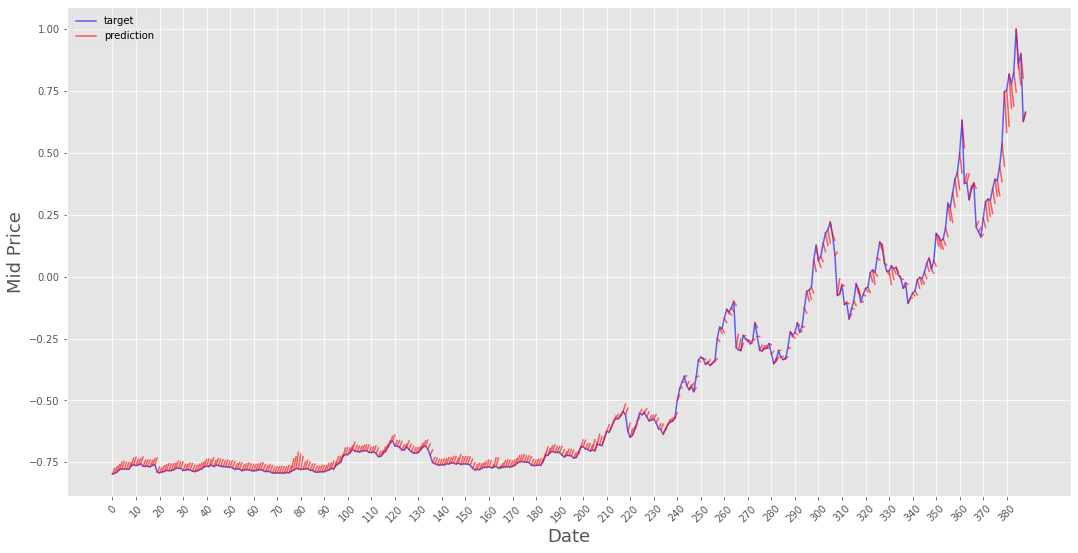

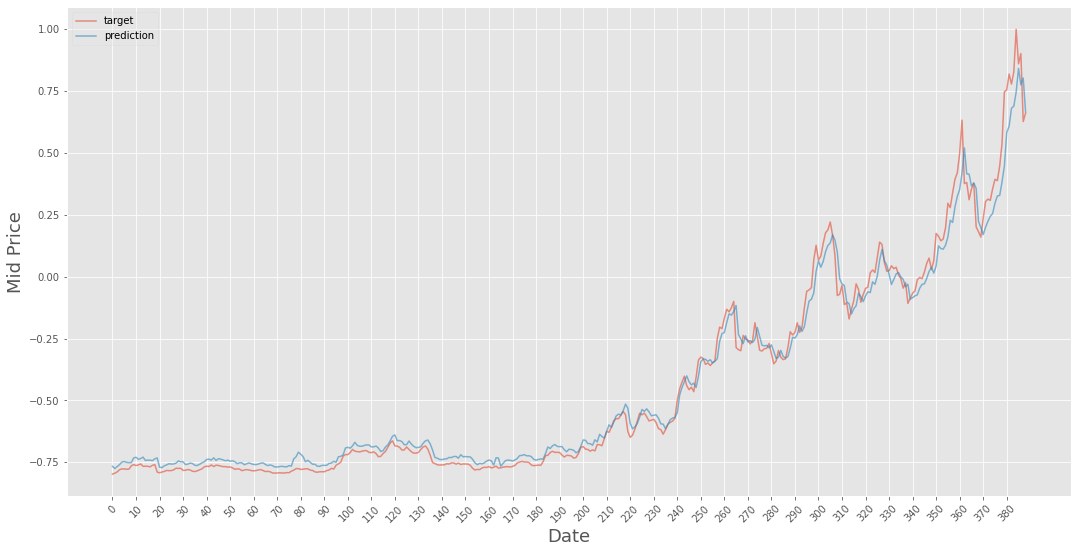

In [13]:
predictions = testPredict
targets_test = test_y[:, -1:].tolist()
# prediction tem um shape (samples, foward_days), entao vamos pegar previsoes de foward_days dias, a cada partir de pontos com intervalo de foward_days
foward_days_predictions = []
for i in range(1, predictions.shape[0], foward_days):
    foward_days_predictions.append(np.array([None]*(i-1) + targets_test[i-1] +
                                            predictions[i].tolist() +
                                            [None]*(predictions.shape[0]-(i+foward_days))))


fig = plot_data([targets_test] + foward_days_predictions, tick=10, legends=['target', 'prediction'],
                colors=['b', 'r'] + ['r']*len(foward_days_predictions), blocking=False)
# 1 day predictions
fig = plot_data([targets_test, predictions[:, 0]], tick=10, legends=['target', 'prediction'], blocking=False)

# Fazendo o mesmo, mas agora prevendo a variação, ao invés do preço

In [ ]:
tf.keras.backend.clear_session() #limpa modelos e dados anteriores, para evitar vazamento de memoria

features = [variation] #+ event_features
target = variation

features_set, labels = to_keras_format(features, target)
train_X, test_X = split_data(features_set, ratio=0.85)
train_y, test_y = split_data(labels, ratio=0.85)


modelo = build_model(train_X, train_y)

opt = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
modelo.compile(optimizer=opt, loss=custom_loss2, metrics=[mean_squared_error, movement_accuracy, above_or_below_zero_accuracy])# 'cosine_similarity', 'mean_squared_error'
modelo.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=40, batch_size=16)  # validation_data=(test_X, test_y)



In [ ]:
plot_train_history(modelo, plot_above_or_below_zero_accuracy=True)

In [ ]:
# train_score = modelo.evaluate(x=train_X, y=train_y, batch_size=1)
test_score = modelo.evaluate(x=test_X, y=test_y, batch_size=1)

testPredict = modelo.predict(test_X)

timestep_size = 0.1
original_vectors = [[timestep_size, test_y[i, -1] - test_y[i-1, -1]] for i in range(1, len(test_y))]
prediction_vectors = [[timestep_size, testPredict[i, -1] - test_y[i-1, -1]] for i in range(1, len(test_y))]
cos_similarity = np.mean(keras_cosine_similarity(original_vectors, prediction_vectors))
print('Cosine similarity %s' % cos_similarity)
mse = mean_squared_error(test_y, testPredict).numpy()
print('Mean Square Error %s' % mse)
upDownScore = movement_accuracy(test_y, testPredict).numpy()
print('Movement accuracy %s' % upDownScore)
above_below_zero = above_or_below_zero_accuracy(test_y, testPredict).numpy()
print('Price up or down accuracy (só é relevante para regressao de porcentagem, não valores brutos): %s' % above_below_zero)

print('Agora que usamos o batch de tamanho 1, temos um resultado semelhante ao calculo manual. Teoria foi confirmada')

In [ ]:
predictions = testPredict
targets_test = test_y[:, -1:].tolist()
# prediction tem um shape (samples, foward_days), entao vamos pegar previsoes de foward_days dias, a cada partir de pontos com intervalo de foward_days
foward_days_predictions = []
for i in range(1, predictions.shape[0], foward_days):
    foward_days_predictions.append(np.array([None]*(i-1) + targets_test[i-1] +
                                            predictions[i].tolist() +
                                            [None]*(predictions.shape[0]-(i+foward_days))))


fig = plot_data([targets_test] + foward_days_predictions, tick=10, legends=['target', 'prediction'],
                colors=['b', 'r'] + ['r']*len(foward_days_predictions), blocking=False)
# 1 day predictions
fig = plot_data([targets_test, predictions[:, 0]], tick=10, legends=['target', 'prediction'], blocking=False)

Como podemos ver, ao tentar prever a variação ao invés do valor bruto, temos resultados melhores.<br/>
Isso acontece devido o escopo de dados ser mais consistente, e consequentemente o modelo não ter que lidar com valores nunca visto antes. Sendo assim, o modelo também será à prova "do futuro"

# Função loss personalizada

Agora vamos comparar o modelo usando a função loss personalizada contra a mais comunente usada `meanSquaredError`.

A função já foi definida em [metrics/custom.py](metrics/custom.py), mas iremos defini-la passo a passo novamente aqui para fins didáticos:

O objetivo desta função loss personalizada é dar valor para a angulação do movimento também, ao invés de apenas a diferença entre o valor esperado e previsto.<br/>
A função, para isso, utiliza a similaridade por cosseno.

na biblioteca _Keras_ sua implementação dá uma saída no intervalo \[-1, 1\], onde quando é um numero negativo entre -1 e 0, 0 indica ortogonalidade e valores mais proximos de -1 indicam maior similaridade. Valores mais proximos a 1 indicam maior dissimilaridade. Por exemplo:

In [14]:
from keras.losses import cosine_similarity as keras_cosine_similarity
# considera-se que os vetores saem da origem
y_true = [[0., 1.], [1., 1.]]
y_pred = [[1., 0.], [1., 1.]]

keras_cosine_similarity(y_true, y_pred, axis=1).numpy()

array([-0.        , -0.99999994], dtype=float32)

Sendo assim, a versão preguiçosa da nossa função loss seria:<br/>
`SquaredError(y_true, y_pred) * CosineSimilarity(y_true, y_pred)`

mas antes devemos tratar de alguns pontos:
 - A similaridade por cosseno lê e compara dois vetores, então devemos antes transformar o y_true e y_pred em vetores que saem da origem;
 - Para isso, precisamos do valor _Y_ e _X_ do vetor, e consequentemente a distância de _Y_, _X_ atuais dos _Y_, _X_ do timestep anterior
 - _Y_ pode ser obtido com a diferença entre o _Y_ atual e o _Y_ do timestep anterior__*__
 - Porém, nossos dados não tem noção de distância entre um timestep e outro (um dia e outro), apenas sabem que um timestep se passou,<br/>
 em outras palavras: não sabemos o valor de _X_


##### *: por isso, durante a preparação de dados, as labels possuem dois valores (valor anterior e atual), ao invés de um único (valor atual)




Então optei por escolher um valor arbitrário, que se adequasse no escopo de valores de y.
Por exemplo, podemos ver que nossos dados da feature _variação (%)_ normalmente variam entre 0.07 e -0.05, e em casos mais extremos entre 0.15 e -0.15,<br/>
então decidi que x=0.1, pois os angulos dos vetores resultantes normalmente ficariam perto mas abaixo de 45°.

A implementação da _similaridade por cosseno_ fica assim: 
 ##### note que _y_true_ tem dois valores (_label_ anterior e atual), mas _y_pred_ apenas um (predição atual), pois não precisamos da predição anterior (a _label_ anterior é usada no lugar).

In [ ]:
from keras.losses import cosine_similarity as keras_cosine_similarity

# y_true.shape = (batch_size, 2)
# y_pred.shape =  (batch_size, 1)

def cosine_similarity_didatico(y_true, y_pred):
    print(f'\ny_true:{y_true}\ny_pred:{y_pred}')

    y_true_firstColumn = y_true[:, :1]  #label do timestep anterior
    y_pred = tf.concat([y_true[:, :1], y_pred], axis=-1)    # junta o valor (label) anterior com a previsao atual
    print(f'\ny_true:{y_true}\ny_pred:{y_pred}')

    y_pred = y_pred - y_true_firstColumn + [0.1, 0]       # move o vetor para sair da origem, e faz eixo x = 0.1
    y_true = y_true - y_true_firstColumn + [0.1, 0]
    print(f'\nagora são vetores saindo da origem,\ny_true:{y_true}\ny_pred:{y_pred}')    # vetores gerados

    return keras_cosine_similarity(y_true, y_pred, axis=-1)  # função de similaridade por cosseno padrão

#exemplo
y_true = [[.0,.01],
          [.01, .06],
          [.06, .09],
          [.09, -.05],
          [-.05, -.02]]
y_pred = [[.01],
          [.04],
          [.05],
          [.03],
          [-.01]]
y_true, y_pred = np.array(y_true), np.array(y_pred)
y_true, y_pred = tf.convert_to_tensor(y_true), tf.convert_to_tensor(y_pred)

print('similaridade por coseno: ', cosine_similarity_didatico(y_true, y_pred))

Agora que conseguimos calcular a similaridade por cosseno, podemos implementar a função de _loss_

In [ ]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
def square_error_didatico(y_true, y_pred): #implementação igual da biblioteca keras, mas adaptada para o nosso formato de y_true
    y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = math_ops.cast(y_true[:, 1:], y_pred.dtype)
    return math_ops.squared_difference(y_pred, y_true)

def custom_loss_didatico(y_true, y_pred):
    c = cosine_similarity_didatico(y_true, y_pred) #valores entre  -1 e 1 (na pratica entre -1 e 0)
    c = (c+1.) #entre  0 e 2 (na pratica 0 e 1)
    c = (c*4)+2 #entre 2 e 10 (na pratica 2 e 6)
    error = tf.reduce_mean(square_error_didatico(y_true, y_pred))

    return error * (tf.reduce_mean(c)**2)

a função cosine_similarity retorna um valor entre -1 e 1, então para não incentivar o aumento de MeanSquaredError (que varia de 0 a 1) quando houver "acertos de direção/angulo", vamos mudar o intervalo de -1 a 1 para  0 a 2.

mas como todos os valores de x são iguais, então o intervalo na pratica é entre -1 e 0, e 0 e 1 depois da conversão.

Também, observou-se que maioria dos valores estão proximos de -1 (0 na pratica), <br/>
então multiplica o valor por 4 para aumentar o range dos valores, deixando o intervalo entre 0 e 8 (0 e 4 na pratica)<br/>
e soma 2, para tornar a diferença de angulação/movimento uma penalizadora (ao invés de recompensadora)

Por fim, também pelo motivo dos valores serem muito proximos de -1, após estender o range de valores multiplicando por 4, o valor é elevado ao quadrado, para captar melhor as grandes diferenças de movimento/angulação.


Também podemos substituir o `MeanSquaredError` pelo `LogCosh`, que se comporta como o `MeanSquaredError` para valores pequenos, mas não penaliza tanto como ele para valores grandes.
##### faz sentido fazer isso, pois no final das contas estamos tirando penalização do erro (diferenca entre valores), e passando para a angulação/movimento.

In [ ]:
from keras.losses import log_cosh
def custom_loss_didatico(y_true, y_pred):
    c = cosine_similarity_didatico(y_true, y_pred) #valores entre  -1 e 1 (na pratica entre -1 e 0)
    c = (c+1.) #entre  0 e 2 (na pratica 0 e 1)
    c = (c*4)+2 #entre 2 e 10 (na pratica 2 e 6)
    error = log_cosh(y_true[:, 1:], y_pred)

    return error * (tf.reduce_mean(c)**2) 

# Comparando MeanSquaredError com função loss personalizada

In [21]:
tf.keras.backend.clear_session() #limpa modelos e dados anteriores, para evitar vazamento de memoria

from metrics.custom import above_or_below_zero_accuracy, movement_accuracy
from metrics.custom import mean_squared_error, cosine_similarity as custom_cosine_similarity

def build_and_run_and_show(features, target, loss_function) -> Model:
    features_set, labels = to_keras_format(features, target)
    train_X, test_X = split_data(features_set, ratio=0.75)
    train_y, test_y = split_data(labels, ratio=0.75)


    model = build_model(train_X, train_y)

    opt = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
    model.compile(optimizer=opt, loss=loss_function, metrics=[mean_squared_error, movement_accuracy, above_or_below_zero_accuracy])# 'cosine_similarity', 'mean_squared_error'
    model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=60, batch_size=16)  # validation_data=(test_X, test_y)

    plot_train_history(model, plot_above_or_below_zero_accuracy=True)

    test_score = model.evaluate(x=test_X, y=test_y, batch_size=1)
    testPredict = model.predict(test_X)

    # timestep_size = 0.1
    # original_vectors = [[timestep_size, test_y[i, -1] - test_y[i-1, -1]] for i in range(1, len(test_y))]
    # prediction_vectors = [[timestep_size, testPredict[i, -1] - test_y[i-1, -1]] for i in range(1, len(test_y))]
    # cos_similarity = np.mean(keras_cosine_similarity(original_vectors, prediction_vectors))
    # print('Cosine similarity %s' % cos_similarity)
    mse = mean_squared_error(test_y, testPredict).numpy()
    print('Mean Square Error %s' % mse)
    upDownScore = movement_accuracy(test_y, testPredict).numpy()
    print('Movement accuracy %s' % upDownScore)
    above_below_zero = above_or_below_zero_accuracy(test_y, testPredict).numpy()
    print('Price up or down accuracy: %s' % above_below_zero)

Epoch 1/20
138/138 [==============================] - 6s 33ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - movement_accuracy: 0.6554 - above_or_below_zero_accuracy: 0.5112 - val_loss: 0.0020 - val_mean_squared_error: 0.0022 - val_movement_accuracy: 0.6645 - val_above_or_below_zero_accuracy: 0.4255
Epoch 2/20
138/138 [==============================] - 4s 29ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - movement_accuracy: 0.6626 - above_or_below_zero_accuracy: 0.5261 - val_loss: 0.0018 - val_mean_squared_error: 0.0019 - val_movement_accuracy: 0.7220 - val_above_or_below_zero_accuracy: 0.5580
Epoch 3/20
138/138 [==============================] - 4s 29ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - movement_accuracy: 0.6645 - above_or_below_zero_accuracy: 0.5391 - val_loss: 0.0018 - val_mean_squared_error: 0.0020 - val_movement_accuracy: 0.7170 - val_above_or_below_zero_accuracy: 0.5530
Epoch 4/20
138/138 [==============================] - 4s 30ms/step - loss: 0.0024 - m

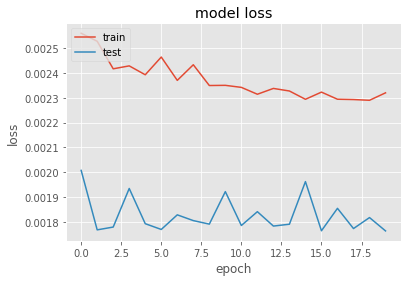

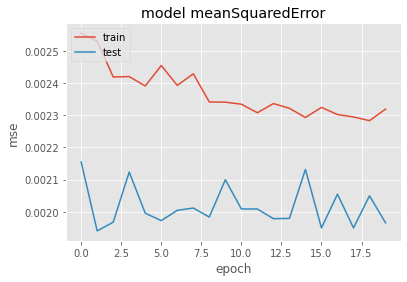

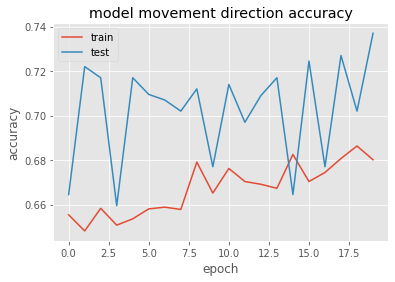

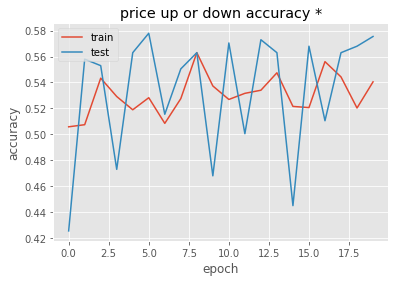

389/389 [==============================] - 2s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - movement_accuracy: 0.7352 - above_or_below_zero_accuracy: 0.5861
Mean Square Error 0.0017647715
Movement accuracy 0.7352185
Price up or down accuracy: 0.5861183


In [19]:
features = [variation] #+ event_features
target = variation
model_mse = build_and_run_and_show(features, target, mean_squared_error)

## como que o historico de loss e de meanSquaredError estao diferentes se sao *exatamente a mesma função* ?????

Epoch 1/20
138/138 [==============================] - 7s 34ms/step - loss: 0.0256 - mean_squared_error: 0.0030 - movement_accuracy: 0.6693 - above_or_below_zero_accuracy: 0.5103 - val_loss: 0.0138 - val_mean_squared_error: 0.0020 - val_movement_accuracy: 0.7095 - val_above_or_below_zero_accuracy: 0.5260
Epoch 2/20
138/138 [==============================] - 4s 31ms/step - loss: 0.0196 - mean_squared_error: 0.0026 - movement_accuracy: 0.6796 - above_or_below_zero_accuracy: 0.5216 - val_loss: 0.0150 - val_mean_squared_error: 0.0021 - val_movement_accuracy: 0.6695 - val_above_or_below_zero_accuracy: 0.4660
Epoch 3/20
138/138 [==============================] - 4s 31ms/step - loss: 0.0163 - mean_squared_error: 0.0023 - movement_accuracy: 0.6669 - above_or_below_zero_accuracy: 0.5540 - val_loss: 0.0129 - val_mean_squared_error: 0.0020 - val_movement_accuracy: 0.7240 - val_above_or_below_zero_accuracy: 0.5580
Epoch 4/20
138/138 [==============================] - 4s 30ms/step - loss: 0.0187 - m

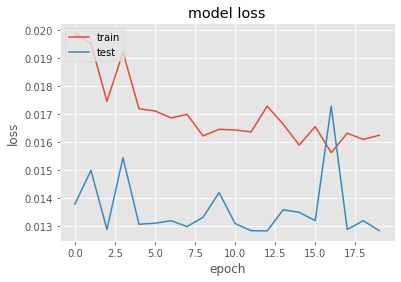

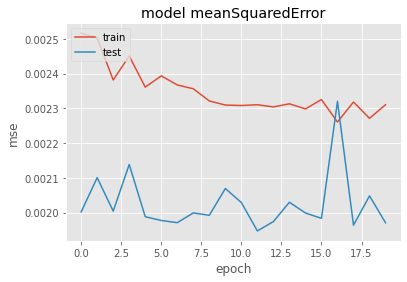

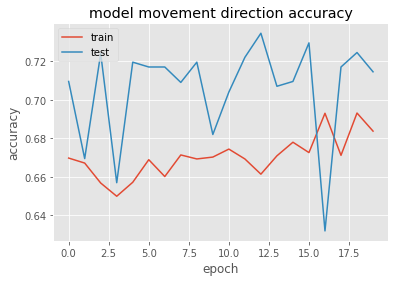

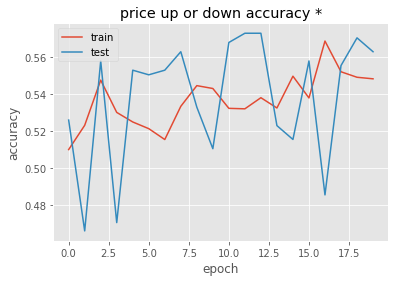

389/389 [==============================] - 2s 4ms/step - loss: 0.0273 - mean_squared_error: 0.0018 - movement_accuracy: 0.7121 - above_or_below_zero_accuracy: 0.5733
Mean Square Error 0.001767252
Movement accuracy 0.71208227
Price up or down accuracy: 0.5732648


In [20]:
tf.keras.backend.clear_session()
from metrics.custom import custom_loss2, custom_loss

features = [variation] #+ event_features
target = variation
model_custom = build_and_run_and_show(features, target, custom_loss2)


In [ ]:
predictions = testPredict_mse
targets_test = test_y[:, -1:].tolist()
# prediction tem um shape (samples, foward_days), entao vamos pegar previsoes de foward_days dias, a cada partir de pontos com intervalo de foward_days
foward_days_predictions = []
for i in range(1, predictions.shape[0], foward_days):
    foward_days_predictions.append(np.array([None]*(i-1) + targets_test[i-1] +
                                            predictions[i].tolist() +
                                            [None]*(predictions.shape[0]-(i+foward_days))))


fig = plot_data([targets_test] + foward_days_predictions, tick=10, legends=['target', 'prediction'],
                colors=['b', 'r'] + ['r']*len(foward_days_predictions), blocking=False)
# 1 day predictions
fig = plot_data([targets_test, predictions[:, 0]], tick=10, legends=['target', 'prediction'], blocking=False)

In [ ]:
predictions = testPredict_custom
targets_test = test_y[:, -1:].tolist()
# prediction tem um shape (samples, foward_days), entao vamos pegar previsoes de foward_days dias, a cada partir de pontos com intervalo de foward_days
foward_days_predictions = []
for i in range(1, predictions.shape[0], foward_days):
    foward_days_predictions.append(np.array([None]*(i-1) + targets_test[i-1] +
                                            predictions[i].tolist() +
                                            [None]*(predictions.shape[0]-(i+foward_days))))


fig = plot_data([targets_test] + foward_days_predictions, tick=10, legends=['target', 'prediction'],
                colors=['b', 'r'] + ['r']*len(foward_days_predictions), blocking=False)
# 1 day predictions
fig = plot_data([targets_test, predictions[:, 0]], tick=10, legends=['target', 'prediction'], blocking=False)

# Comparando adição de novas features

Epoch 1/20
138/138 [==============================] - 7s 33ms/step - loss: 0.1712 - mean_squared_error: 0.1712 - movement_accuracy: 0.5819 - above_or_below_zero_accuracy: 0.5201 - val_loss: 0.0021 - val_mean_squared_error: 0.0022 - val_movement_accuracy: 0.6695 - val_above_or_below_zero_accuracy: 0.4235
Epoch 2/20
138/138 [==============================] - 4s 31ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - movement_accuracy: 0.6388 - above_or_below_zero_accuracy: 0.5112 - val_loss: 0.0018 - val_mean_squared_error: 0.0020 - val_movement_accuracy: 0.7220 - val_above_or_below_zero_accuracy: 0.5460
Epoch 3/20
138/138 [==============================] - 4s 32ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - movement_accuracy: 0.6443 - above_or_below_zero_accuracy: 0.5198 - val_loss: 0.0018 - val_mean_squared_error: 0.0020 - val_movement_accuracy: 0.7245 - val_above_or_below_zero_accuracy: 0.5660
Epoch 4/20
138/138 [==============================] - 4s 31ms/step - loss: 0.0028 - m

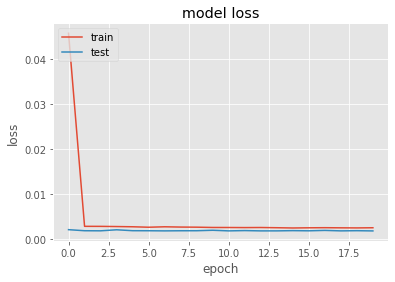

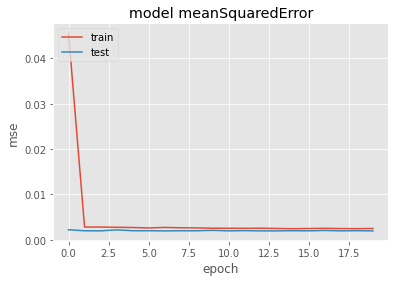

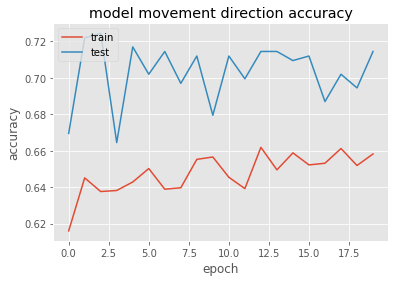

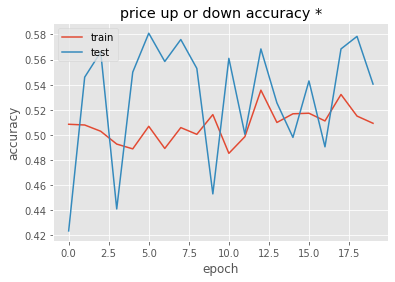

389/389 [==============================] - 2s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - movement_accuracy: 0.7121 - above_or_below_zero_accuracy: 0.5501
Mean Square Error 0.0018014172
Movement accuracy 0.71208227
Price up or down accuracy: 0.5501285


In [18]:
tf.keras.backend.clear_session() #limpa modelos e dados anteriores, para evitar vazamento de memoria

from metrics.custom import above_or_below_zero_accuracy, movement_accuracy
from metrics.custom import mean_squared_error, cosine_similarity as custom_cosine_similarity

features = [variation] + event_features
target = variation

model_events = build_and_run_and_show(features, target, mean_squared_error)

In [ ]:
tf.keras.backend.clear_session() #limpa modelos e dados anteriores, para evitar vazamento de memoria

features = [variation, google_trends, tweet]
target = variation

model_social = build_and_run_and_show(features, target, mean_squared_error)